In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from scipy import stats

data = pd.read_csv('winequality-red.csv')

# Data Preprocessing

In [2]:
# Check the first few rows of the dataset to understand its structure
print("Original Data Sample:")
print(data.head())

Original Data Sample:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5 

In [3]:
# Check for missing values
print("\nMissing Values Check:")
print(data.isnull().sum())



Missing Values Check:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [4]:
# Convert wine quality to binary (Good = 1, Not Good = 0)
# Wines with quality score >= 7 as 'Good', others as 'Not Good'
data['quality'] = data['quality'].apply(lambda x: 1 if x >= 7 else 0)


In [5]:
# The distribution of quality after conversion
print("\nQuality Distribution after Conversion (Good = 1, Not Good = 0):")
print(data['quality'].value_counts())


Quality Distribution after Conversion (Good = 1, Not Good = 0):
quality
0    1382
1     217
Name: count, dtype: int64


In [6]:
# Outlier detection using Z-score and removal
# Calculate Z-scores for the features (excluding the target variable quality)
z_scores = np.abs(stats.zscore(data.drop('quality', axis=1)))
threshold = 3

In [7]:
outliers_per_feature = (z_scores > threshold).sum(axis=0)
print("\nOutliers Detected (Z-score > 3):")
print(outliers_per_feature)


Outliers Detected (Z-score > 3):
fixed acidity           12
volatile acidity        10
citric acid              1
residual sugar          30
chlorides               31
free sulfur dioxide     22
total sulfur dioxide    15
density                 18
pH                       8
sulphates               27
alcohol                  8
dtype: int64


In [8]:
# Clean the data by removing rows with any outliers
data_clean = data[(z_scores < threshold).all(axis=1)]

In [9]:
# Check how many rows were removed due to outliers
print("\nBefore and After Removing Outliers:")
print(f"Original dataset size: {data.shape[0]} rows")
print(f"Cleaned dataset size: {data_clean.shape[0]} rows")
print(f"Number of rows removed: {data.shape[0] - data_clean.shape[0]}")


Before and After Removing Outliers:
Original dataset size: 1599 rows
Cleaned dataset size: 1458 rows
Number of rows removed: 141


In [10]:
# Split the data into features (X) and labels (y)
X = data_clean.drop('quality', axis=1)  # Features (inputs)
y = data_clean['quality']  # Labels (output)

# Check feature distribution
print("\nFeature Distribution:")
print(X.describe())


Feature Distribution:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1458.000000       1458.000000  1458.000000     1458.000000   
mean        8.312551          0.524050     0.265281        2.388717   
std         1.647635          0.169451     0.191271        0.865307   
min         5.000000          0.120000     0.000000        1.200000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.200000          0.635000     0.420000        2.600000   
max        13.500000          1.040000     0.790000        6.700000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1458.000000          1458.000000           1458.000000  1458.000000   
mean      0.081531            15.089849             43.660494     0.996718   
std       0.021218             9.317669             29.414615     0.001718   
min       0.038000       

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#  Machine Learning

In [12]:
# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate Random Forest performance (AUC)
y_pred_rf = rf_model.predict(X_test)
auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
print(f'\nRandom Forest AUC: {auc_rf:.2f}')


Random Forest AUC: 0.92


In [13]:
# Additional metrics for Random Forest
print("\nRandom Forest Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       252
           1       0.76      0.55      0.64        40

    accuracy                           0.91       292
   macro avg       0.85      0.76      0.79       292
weighted avg       0.91      0.91      0.91       292



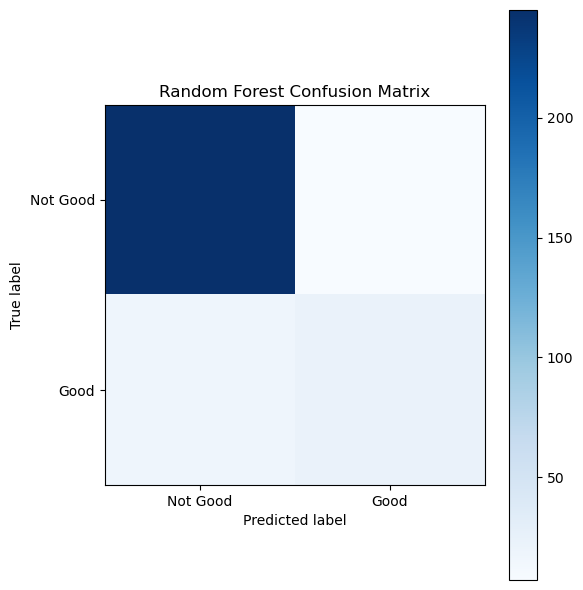

In [14]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,6))
plt.imshow(cm_rf, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Not Good', 'Good'])
plt.yticks([0, 1], ['Not Good', 'Good'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

We trained a Random Forest classifier and assessed its performance on test data using the AUC (Area Under the Curve) along with other classification metrics. 

The confusion matrix provides insight into the counts of true and false predictions by the model.

The plot visualizes the Random Forest model's confusion matrix, aiding in understanding the accuracy of wine classification, showing both correct and incorrect classifications.

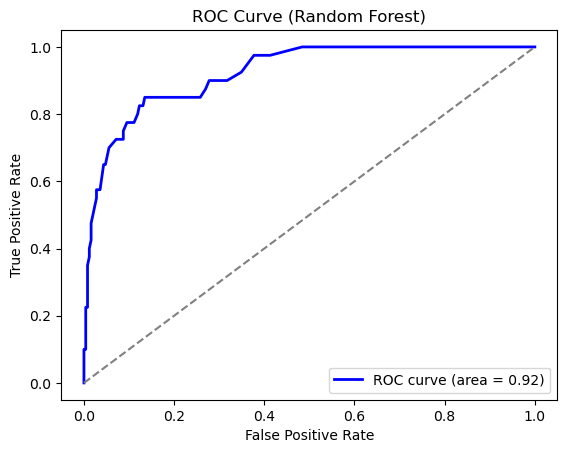

In [15]:
# ROC Curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend(loc='lower right')
plt.show()

The plot displays the ROC curve for the Random Forest model, offering a visual depiction of how well the model performs across various classification thresholds. A higher AUC indicates superior model performance.

# Deep Learning

In [16]:
# Standardize features for neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the Neural Network model
nn_model = Sequential([
    Input(shape=(X.shape[1],)),  # Input layer
    Dense(64, activation='relu'),  # Hidden layer 1
    Dense(32, activation='relu'),  # Hidden layer 2
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

# Compile the model
nn_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
# Training the model
nn_model.fit(X_scaled, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6434 - loss: 0.6295 - val_accuracy: 0.9178 - val_loss: 0.3302
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8540 - loss: 0.3776 - val_accuracy: 0.9212 - val_loss: 0.2583
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8859 - loss: 0.3088 - val_accuracy: 0.9178 - val_loss: 0.2427
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8707 - loss: 0.3136 - val_accuracy: 0.9212 - val_loss: 0.2384
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8805 - loss: 0.3006 - val_accuracy: 0.9247 - val_loss: 0.2282
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8713 - loss: 0.2770 - val_accuracy: 0.9144 - val_loss: 0.2259
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8943 - loss: 0.2578 - val_accuracy: 0.9110 - val_loss: 0.2339
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9007 - loss: 0.2310 - val_accuracy: 0.9212 - val_loss:

In [18]:
# Evaluate performance (AUC)
y_pred_nn_proba = nn_model.predict(X_scaled)
fpr_nn, tpr_nn, _ = roc_curve(y, y_pred_nn_proba)
roc_auc_nn = auc(fpr_nn, tpr_nn)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step


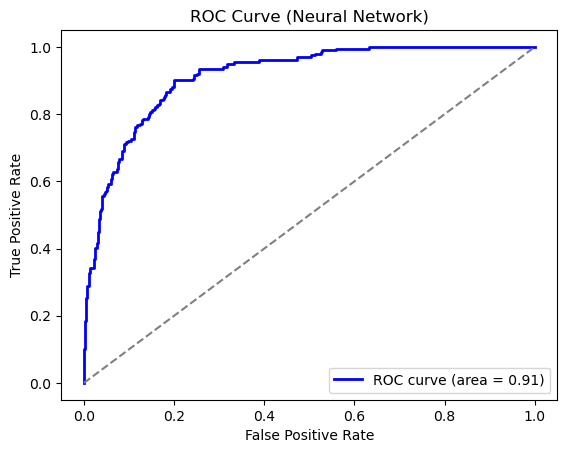

In [19]:
# ROC Curve for Neural Network
plt.plot(fpr_nn, tpr_nn, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_nn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Neural Network)')
plt.legend(loc='lower right')
plt.show()

The plot presents the ROC curve for the neural network model, providing a visual representation of its effectiveness in differentiating between "Good" and "Not Good" wines.

In [20]:
# Check accuracy on the validation split during training
accuracy = nn_model.evaluate(X_scaled, y, verbose=0)  # Evaluate on the whole dataset
print(f'\nNeural Network Accuracy: {accuracy[1]*100:.2f}%')


Neural Network Accuracy: 90.40%


## Conclusion:

### Random Forest: 

Attained an AUC of 0.92, demonstrating excellent capability in differentiating between "Good" and "Not Good" wines.

### Neural Network: 

Likewise showed strong performance, with a notably high accuracy on the dataset.

Overall, both models were effective, though the Random Forest model slightly outperformed the Neural Network in terms of AUC.